## CNN

### 영상분류

- 컴퓨터 비전 분야의 핵심 태스크

#### 영상분류의 어려운 점
- Semantic gap - 의미적 간극. 모델이 저수준 데이터를 조합해 고수준 의미를 추론하기 어려움
- Viewpoint variation. 시점 변화. 객체가 카메라가 보는 시점에 따라 다르게 보이는 문제
- Illumination - 조명변화. 동일한 객체라도 조명의 강도, 방향, 색온도 등에 따라 다르게 보이는 현상
- Deformation - 변형. 객체가 행태적으로 변형될 때 생기는 문제. 전혀 이상한 모습으로 있을때 다르게 보임
- Occlusion - 가림. 객체의 일부가 다른 물체에 의해 가려지는 현상
- Background clutter - 배경혼잡. 객체와 구분되는 배경이 복잡하거나 비슷한 특징을 가지고 있어 분류를 방해
- Intralass variation - 클래스 내부 변이. 같은 클래스 내에서도 개체별로 다양한 형태를 가지는 경우. 

#### Data-driven approach
- 이미지와 라벨 데이터를 수집
- 머신러닝을 사용해서 image classifier를 훈련
- 테스트 이미지에 대해서 학습된 모델 성능 평가

### Convolution 연산 = filtering 작업
- 영상 내 필요한 정보만 통과시키고 원치 않는 정보를 걸러내는 작업
- 신호처리나 딥러닝에서 두 함수의 결합을 표현하는 연산으로, 하나의 함수(주로 커널 또는 필터)가 다른 함수(입력 데이터)에 특정 패턴을 찾거나 변환하는 방식으로 작동. 딥러닝에서 Convolution은 주로 이미지 데이터에서 특정 특징(예: 엣지, 모양, 텍스처)을 추출하는 데 사용


    <img src="https://raw.githubusercontent.com/hugoMGSung/study-pytorch/refs/heads/main/images/torch0016.png" width="600">


#### 계속
- Filter (혹은 kernel)라고 불리는 규정된 영역을 기반으로 연산 수해
- Filter 계수에 따라 출력이 결정

    $$ s(t)=(x∗w)(t)=∫x(a)w(t−a)da $$

    - x(a): 입력 함수 (데이터)
    - w(t−a): 커널(필터) 함수
    - s(t): 결과 값 (출력)

#### CNN

<img src="https://raw.githubusercontent.com/hugoMGSung/study-pytorch/refs/heads/main/images/torch0017.png" width="800">

- 사진이 입력되면 특징 추출. 새 이미지가 입력되면, 부리의 크기, 눈의 모양, 깃털 등 나누어서 파악 -> 컨볼루션
    - 특징을 추출하는 패턴은 정사각형 모양 필터, 보통 3x3 
- 왼쪽 상단부터 오른쪽으로 이동하면서 각 위치마다 포개지는 숫자를 곱해서 모두 합산 -> 특성 맵(기록 결과)
    - 핕터이 특성이 입력 사진 어느 부분에 많이 존재하는지 확인 가능
    - 특성 맵의 위치의 값이 높으면 그 위치가 필터와 유사하다는 의미
    - 신경망은 각 연결이 가중치를 학습하지만, CNN은 고정 연결이 없어 컨볼루션 과정으로 출력을 계산
    - 사람이 아닌 모델 스스로 어느 특징이 좋은지 학습을 통해 필터를 생성
- 필터의 개수만큼 생성된 특성 맵의 크기를 줄임 -> 맥스 풀링
    - 가장 큰 값만 추출하여 출력을 작게 만드는 방법
- 맥스풀링된 맵을 하나의 단위로 여러층으로 깊에 쌓아올림 -> 패턴담긴 특성 맵
    - 낮은 층에서 단순한 패턴, 높은 층에서 복잡한 패턴을 추상화
- 이 구조를 완전연결 신경망에 붙여 특성 맵을 사진의 클래스로 최종 분류


##### 전체 처리과정 구조도 1

<img src="https://raw.githubusercontent.com/hugoMGSung/study-pytorch/refs/heads/main/images/torch0018.png" width="800">


##### 전체 처리과정 구조도 2

<img src="https://raw.githubusercontent.com/hugoMGSung/study-pytorch/refs/heads/main/images/torch0019.png" width="800">



### CNN 모델 실습

#### CIFAR-19 dataset
- 60,000 32x32 color images (50,000 training, 10,000 test)
- 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)

In [13]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader

import os
import matplotlib.pyplot as plt

##### 분류 정확도 측정

1. output.topk:
    - 모델의 예측 결과에서 상위 k개의 가장 높은 확률값을 가지는 클래스 인덱스를 추출
    - 예를 들어, k=5라면, 각 샘플에 대해 상위 5개의 가장 높은 값과 해당 인덱스를 반환

2. correct:
    - 모델의 예측 결과 pred와 실제 정답 target을 비교하여 일치하는 경우를 기록한 불린 배열

3. correct[:k].view(-1).float().sum():
    - k개의 예측 중 실제로 정답과 일치한 개수를 계산

4. acc.append(correct_k.mul(1 / batch_size)):
    - k개의 예측 중 맞은 개수를 배치 크기로 나누어 정확도를 계산

In [5]:
def accuracy(output, target, topk=(1,)):
    """
    모델의 예측 정확도를 top-k 기준으로 계산

    매개변수:
        output (torch.Tensor): 모델이 출력한 예측 값으로, 형태는 (배치 크기, 클래스 수)
        target (torch.Tensor): 정답 라벨, 형태는 (배치 크기)
        topk (tuple of int): 계산할 top-k 정확도의 기준을 지정 예) top-1,top-5.

    반환값:
        acc (list of torch.Tensor): 각 k에 대한 top-k 정확도를 저장한 리스트(퍼센트 값)
        num_cor (list of torch.Tensor): 각 k에 대해 맞춘 정답의 개수를 저장한 리스트
    """
    with torch.no_grad(): # 이 블록 안에서 기울기 계산을 비활성화(메모리 절약 및 계산 속도 개선)
        maxk = max(topk)  # top-k 중 가장 큰 k를 도출
        batch_size = target.size(0) ## 배치크기 가져오기

        # `output`에서 top-k에 해당하는 가장 높은 값을 가진 클래스 인덱스를 가져오기
        _, pred = output.topk(maxk, 1, True, True)  # `topk`는 (값, 인덱스)를 반환
        pred = pred.t()  # pred를 전치(transpose)하여 (k, batch_size) 형태로 변경

        # `pred`와 `target`을 비교하여 맞춘 결과를 기록
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        acc = []        # 각 k에 대한 정확도를 저장할 리스트
        num_cor = []    # 각 k에 대해 맞춘 정답의 개수를 저장할 리스트

        # top-k의 각 k에 대해 정확도를 계산
        for k in topk:
            # `correct[:k]`에서 k개의 예측 중 맞은 개수를 확인
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True) # k개를 펼쳐서 합산
            num_cor.append(correct_k.clone())  # 맞춘 정답 개수를 저장
            acc.append(correct_k.mul(1/ batch_size))  # 정확도 계산 (정답 개수 / 배치 크기)

    return acc, num_cor  # 각 k에 대한 정확도와 정답 개수 반환

##### 가중치 초기화 함수

In [19]:
def init_weights(m, init_type='normal', init_gain=0.02):
    """
    모델의 가중치를 초기화하는 함수.

    매개변수:
        m (nn.Module): 초기화할 레이어(모듈).
        init_type (str): 가중치 초기화 방식. ['normal', 'xavier', 'kaiming', 'orthogonal'] 중 선택.
        init_gain (float): 초기화 시 사용할 scaling factor (xavier, normal, orthogonal에서 사용).

    설명:
        이 함수는 주어진 레이어의 가중치를 초기화. Conv 또는 Linear 레이어는 가중치를
        지정된 방식에 따라 초기화하고, BatchNorm2d 레이어는 별도의 방식으로 초기화.
    """

    classname = m.__class__.__name__  # 현재 레이어의 클래스 이름 체크

    # Conv 또는 Linear 레이어인지 확인 (weight 속성이 있는 경우)
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        # 초기화 유형에 따라 가중치를 초기화
        if init_type == 'normal':       # 정규분포 초기화
            nn.init.normal_(m.weight.data, 0.0, init_gain)
        elif init_type == 'xavier':     # Xavier 정규분포 초기화
            nn.init.xavier_normal_(m.weight.data, gain=init_gain)
        elif init_type == 'kaiming':    # Kaiming He 초기화 (ReLU 기반 네트워크에 적합)
            nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        elif init_type == 'orthogonal': # 직교 행렬 초기화
            nn.init.orthogonal_(m.weight.data, gain=init_gain)
        else: # 이외 유형 예외처리
            raise NotImplementedError(f'Initialization method "{init_type} is not implemented."')
        
        # 레이어에 bias가 존재하면 0으로 초기화
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

    # BatchNorm2d 레이어일 경우 별도 초기화     
    elif classname.find('BatchNorm2d') != -1:
        # 가중치는 평균 1.0, 분산 init_gain인 정규분포로 초기화
        nn.init.normal_(m.weight.data, 1.0, init_gain)
        nn.init.constant_(m.bias.data, 0.0)  # 편향(bias)는 0(특정상수)으로 초기화

##### CNN 클래스 정의

In [25]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(7,7), stride=(1,1))
        self.conv2 = nn.Conv2d(32, 64, (3,3), (1,1))
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.fc_code = nn.Linear(in_features=128, out_features=128)
        self.fc_output = nn.Linear(128, 10)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=0.5)
        self.apply(init_weights)

    def forward(self, x):
        feature_map = self.conv1(x)
        activated = self.relu(feature_map)
        compressed = self.maxpool(activated)
        x = self.maxpool(self.relu(self.conv2(compressed)))
        x = self.maxpool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        code = self.dropout(self.relu(self.fc_code(x)))
        output = self.fc_output(code)
        return output, code


##### 데이터셋 준비

- torchvision.transforms - 데이터 증강을 위한 다양한 변환 제공
- transforms.RandomHorizontalFlip() - 랜덤 좌우 반전
- transforms.ToTensor() - 데이터를 Pytorch Tensor로 변환
- transforms.Normalize() - 데이터 normalization 적용
- num_workers - CPU -> GPU 데이터로드시 사용하는 코어개수

In [15]:
if not os.path.isdir('./ckpt'):
    os.makedirs('./ckpt')

if not os.path.isdir('./CIFAR_data'):
    os.makedirs('./CIFAR_data')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_transoform = transforms.Compose([transforms.RandomHorizontalFlip(), 
                                       transforms.ToTensor(), 
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
test_transoform = transforms.Compose([transforms.RandomHorizontalFlip(), 
                                       transforms.ToTensor(), 
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

trainset = torchvision.datasets.CIFAR10(root='./CIFAR_data', train=True, download=True, transform=train_transoform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./CIFAR_data', train=False, download=True, transform=test_transoform)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

cuda
Files already downloaded and verified
Files already downloaded and verified


In [26]:
##### 모델, 옵티마이저, 손실함수
model = Network()
model.to(device)
params = model.parameters()
optimizer = optim.Adam(params, lr=1e-3, betas=(0.9, 0.999), weight_decay=0.001)
train_criterion = nn.CrossEntropyLoss(reduction='mean')

##### CNN 모델 실습

- 전체 처리에 40여분이 소요되므로 주의 필요

In [28]:
for epoch in range(1, 100):
    model.train()
    for step, (data, targets) in enumerate(trainloader):
        data = data.to(device, dtype=torch.float)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs, code = model(data)
        loss = nn.CrossEntropyLoss(reduction='mean')(outputs, targets)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        acc, _ = accuracy(outputs, targets)
        acc = acc[0].item()

        if step % 10 == 0:
            print(f'Epoch {epoch} Step {step}/{len(trainloader)} Loss {loss:.4f} Accuracy {acc:.4f}')

    model.eval()
    total_cor = 0
    total_samples = 0

    with torch.no_grad():
        for step, (data, targets) in enumerate(testloader):
            data = data.to(device, dtype=torch.float)
            targets = targets.to(device)

            outputs, code = model(data)
            _, num_cor = accuracy(outputs, targets)
            num_cor = num_cor[0].item()

            total_samples += data.size(0)
            total_cor += num_cor
        
        acc = total_cor / total_samples
        print(f'Epoch {epoch} / Accuracy {acc:.4f}')

    path = f'./ckpt/model_state_{epoch}.st'
    torch.save(model.state_dict(), path)  ## 학습모델의 파라미터

Epoch 1 Step 0/1563 Loss 2.3025 Accuracy 0.1250
Epoch 1 Step 10/1563 Loss 2.3026 Accuracy 0.0938
Epoch 1 Step 20/1563 Loss 2.2815 Accuracy 0.1562
Epoch 1 Step 30/1563 Loss 2.1492 Accuracy 0.1250
Epoch 1 Step 40/1563 Loss 2.1574 Accuracy 0.1562
Epoch 1 Step 50/1563 Loss 2.1982 Accuracy 0.0625
Epoch 1 Step 60/1563 Loss 1.9314 Accuracy 0.3438
Epoch 1 Step 70/1563 Loss 2.1989 Accuracy 0.1562
Epoch 1 Step 80/1563 Loss 2.1263 Accuracy 0.0938
Epoch 1 Step 90/1563 Loss 2.2638 Accuracy 0.2188
Epoch 1 Step 100/1563 Loss 1.9816 Accuracy 0.2812
Epoch 1 Step 110/1563 Loss 2.3404 Accuracy 0.1562
Epoch 1 Step 120/1563 Loss 2.2318 Accuracy 0.0625
Epoch 1 Step 130/1563 Loss 2.1506 Accuracy 0.1875
Epoch 1 Step 140/1563 Loss 2.1759 Accuracy 0.1250
Epoch 1 Step 150/1563 Loss 1.9630 Accuracy 0.1875
Epoch 1 Step 160/1563 Loss 2.0435 Accuracy 0.2188
Epoch 1 Step 170/1563 Loss 2.0130 Accuracy 0.1875
Epoch 1 Step 180/1563 Loss 2.0889 Accuracy 0.3438
Epoch 1 Step 190/1563 Loss 1.9342 Accuracy 0.1250
Epoch 1 Ste

##### 학습된 Convolution 가중치 확인

In [29]:
def plot_tensor(tensor, mode=1, num_col=None, label=None):
    tensor = tensor.detach().cpu()  ## detach from tensor graph
    img_grid = torchvision.utils.make_grid(tensor, nrow=num_col, padding=2, pad_value=1, normalize=True)

    plt.imshow(img_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

C:\Users\perso\AppData\Local\Temp\ipykernel_33256\894903236.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./ckpt/model_state_99.st')


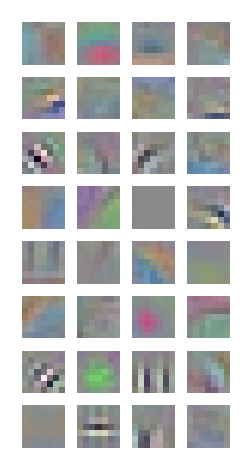

In [30]:
state_dict = torch.load('./ckpt/model_state_99.st')
model.load_state_dict(state_dict, strict=True)
weight_tensor = model.conv1.weight
plot_tensor(weight_tensor, mode=2, num_col=4)

##### 테스트

['cat', 'ship', 'ship', 'plane', 'frog', 'frog', 'car', 'frog', 'cat', 'car', 'plane', 'truck', 'dog', 'horse', 'truck', 'ship', 'dog', 'horse', 'ship', 'frog', 'horse', 'plane', 'deer', 'truck', 'dog', 'bird', 'deer', 'plane', 'truck', 'frog', 'frog', 'dog']
['cat', 'ship', 'ship', 'plane', 'frog', 'frog', 'car', 'frog', 'cat', 'truck', 'plane', 'truck', 'cat', 'horse', 'truck', 'deer', 'dog', 'dog', 'ship', 'frog', 'horse', 'plane', 'bird', 'truck', 'deer', 'deer', 'deer', 'frog', 'truck', 'frog', 'frog', 'dog']


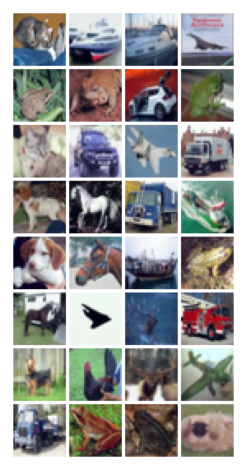

In [31]:
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')
model.eval()

with torch.no_grad():
    for step, (data, targets) in enumerate(testloader):
        data = data.to(device, dtype=torch.float)
        output, _ = model(data)
        _, pred = output.topk(1, 1, True, True)
        target_cls = [classes[x] for x in targets.cpu().numpy()]
        pred_cls = [classes[x] for x in pred.cpu().squeeze().numpy()]

        print(target_cls, pred_cls, sep='\n')

        plot_tensor(data, mode=2, num_col=4, label=[target_cls, pred_cls])
        break